In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import re
from tqdm import tqdm
import time


# Load the .env file
load_dotenv()

df = pd.read_csv('Data/bbc_news_reasons.csv')

In [2]:
df

,text_id,text,original_code,replicated_code,model_code,reason
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ..."
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ..."
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...
...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa..."
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...


In [2]:
# Drop all rows that contain any missing values
df = df.dropna()
df.reset_index

# Check the DataFrame after dropping rows with missing values
df

,text_id,text,original_code,replicated_code,model_code,reason
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ..."
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ..."
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...
...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa..."
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...


In [4]:
df.value_counts('original_code')

original_code
politics         25
sport            25
business         20
entertainment    17
tech             11
Name: count, dtype: int64

In [5]:
df.value_counts('replicated_code')


replicated_code
politics         30
sport            24
business         17
entertainment    17
tech             10
Name: count, dtype: int64

In [6]:
df.value_counts('model_code')

model_code
politics         34
sport            23
business         18
entertainment    14
tech              9
Name: count, dtype: int64

/var/folders/x3/c_04y5q55q39m9sp2tty7lp40000gn/T/ipykernel_15396/3886461982.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] - width, original_code_counts[i] + 0.5, str(original_code_counts[i]), ha='center')
/var/folders/x3/c_04y5q55q39m9sp2tty7lp40000gn/T/ipykernel_15396/3886461982.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i], replicated_code_counts[i] + 0.5, str(replicated_code_counts[i]), ha='center')
/var/folders/x3/c_04y5q55q39m9sp2tty7lp40000gn/T/ipykernel_15396/3886461982.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versi

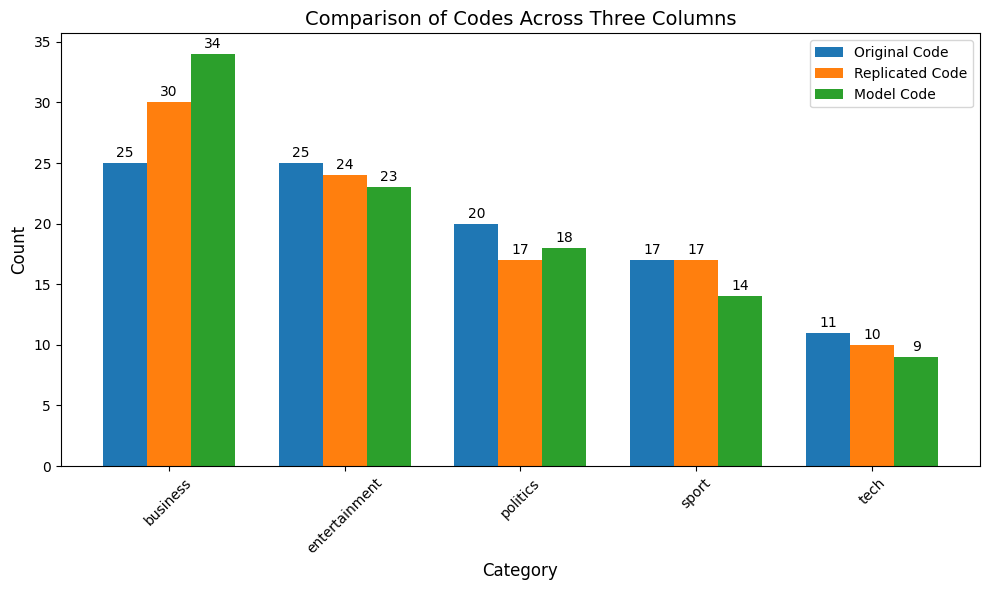

In [5]:
# Categories for the x-axis (you can extract this from your df)
categories = sorted(set(df['original_code']) | set(df['replicated_code']) | set(df['model_code']))

# Get value counts for each column, reindex to align with all categories
original_code_counts = df['original_code'].value_counts()
replicated_code_counts = df['replicated_code'].value_counts()
model_code_counts = df['model_code'].value_counts()

# Number of categories
n = len(categories)

# Create a range for the x-axis based on the number of categories
x = np.arange(n)

# Set the width of the bars
width = 0.25

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, original_code_counts, width, label='Original Code')
plt.bar(x, replicated_code_counts, width, label='Replicated Code')
plt.bar(x + width, model_code_counts, width, label='Model Code')

# Add labels, title, and custom x-axis tick labels
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Comparison of Codes Across Three Columns', fontsize=14)
plt.xticks(x, categories, rotation=45)

# Loop through each bar and add the value labels
for i in range(n):
    plt.text(x[i] - width, original_code_counts[i] + 0.5, str(original_code_counts[i]), ha='center')
    plt.text(x[i], replicated_code_counts[i] + 0.5, str(replicated_code_counts[i]), ha='center')
    plt.text(x[i] + width, model_code_counts[i] + 0.5, str(model_code_counts[i]), ha='center')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### BBC News Codebook

| Code Name    | Original Code Description                       | Revised Code Description                           |
|--------------|--------------------------------------------------|----------------------------------------------------|
| business     | Is this news story about business?               | Is this news story about business?                 |
| entertainment| Is this news story about entertainment?          | Is this news story about entertainment?            |
| politics     | Is this news story about politics?               | Is this news story about politics?                 |
| sport        | Is this news story about sports?                 | Is this news story about sports?                   |
| tech         | Is this news story about tech?                   | Is this news story about tech?                     |


### Column Explanations
- **text_id**: Unique ID for each text document
- **code_id**: Unique ID for each code category
- **text**: Document text that's been coded
- **original_code**: Coded response from the original datasets
- **replicated_code**: Coded response from independent coding exercise from our study team
- **model_code**: Coded response generated from the LLM (GPT-3.5-turbo)
- **reason**: LLM generated reason for coding decision


In [29]:
df

,text_id,text,original_code,replicated_code,model_code,reason
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ..."
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ..."
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...
...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa..."
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...


In [15]:
import os
import time
import requests
import re
from dotenv import load_dotenv
import pandas as pd

def prepare_prompt(text):
    prompt = f"""[INST] Classify this news story into ONE category. Output exactly two lines:
Line 1: Code: [write one category from: business, entertainment, politics, sport, or tech]
Line 2: Reason: [write one sentence explanation]

Text:
{text}
[/INST]"""
    return prompt

def classify_text(text, retry_count=3, retry_delay=1):
    """Classify text with improved error handling and response parsing."""
    for attempt in range(retry_count):
        try:
            headers = {
                "Authorization": f"Bearer {os.getenv('TOGETHER_API_KEY')}",
                "Content-Type": "application/json"
            }
            
            data = {
                "model": "meta-llama/Llama-3.3-70B-Instruct-Turbo",
                "prompt": prepare_prompt(text),
                "max_tokens": 500,
                "temperature": 0.1
            }
            
            response = requests.post(
                'https://api.together.xyz/inference',
                json=data,
                headers=headers
            )
            response.raise_for_status()
            
            output = response.json().get('output', {}).get('choices', [{}])[0].get('text', '')
            
            if not output:
                raise ValueError("Empty response from API")
            
            # Extract code using regex
            code_match = re.search(r'Code:\s*(\w+)', output, re.IGNORECASE)
            code = code_match.group(1).lower() if code_match else "unknown"
            
            # Extract reasoning
            reason_match = re.search(r'Reason:\s*(.+?)(?=\[\/INST\]|$)', output, re.IGNORECASE)
            reason = reason_match.group(1).strip() if reason_match else "No reasoning provided"
            
            # Validate code
            valid_codes = {'business', 'entertainment', 'politics', 'sport', 'tech'}
            if code not in valid_codes:
                code = "unknown"
            
            return code, reason
            
        except Exception as e:
            if attempt == retry_count - 1:
                return "error", f"Classification failed: {str(e)}"
            time.sleep(retry_delay * (attempt + 1))
            continue

def process_dataframe(df, batch_size=100, save_interval=500):
    """Process DataFrame with improved tracking and error handling."""
    df_processed = df.copy()
    
    # Initialize columns if they don't exist
    if 'model_prediction' not in df_processed.columns:
        df_processed['model_prediction'] = None
    if 'reasoning' not in df_processed.columns:
        df_processed['reasoning'] = None
    
    # Get unprocessed rows
    unprocessed_mask = df_processed['model_prediction'].isna()
    total_unprocessed = unprocessed_mask.sum()
    
    if total_unprocessed == 0:
        print("All rows have already been processed!")
        return df_processed
    
    print(f"Processing {total_unprocessed} unprocessed rows...")
    
    success_count = 0
    error_count = 0
    
    for idx in df_processed[unprocessed_mask].index:
        try:
            text = df_processed.loc[idx, 'text']
            code, reasoning = classify_text(text)
            
            df_processed.loc[idx, 'model_prediction'] = code
            df_processed.loc[idx, 'reasoning'] = reasoning
            
            if code != "error":
                success_count += 1
            else:
                error_count += 1
            
            if (success_count + error_count) % save_interval == 0:
                df_processed.to_csv('intermediate_results.csv', index=False)
                print(f"\nSaved intermediate results after processing {success_count + error_count} rows")
            
            if (success_count + error_count) % batch_size == 0:
                time.sleep(1)  # Rate limiting
                
        except Exception as e:
            print(f"\nError processing row {idx}: {str(e)}")
            error_count += 1
            continue
    
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {success_count} rows")
    print(f"Errors: {error_count} rows")
    
    return df_processed

In [17]:
df_results = process_dataframe(df)

Processing 98 unprocessed rows...

Processing complete!
Successfully processed: 98 rows
Errors: 0 rows


In [18]:
df_results

,text_id,text,original_code,replicated_code,model_code,reason,model_prediction,reasoning
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ...",sport,The news story is about a rugby player and his...
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ...",sport,"The news story is about a tennis tournament, s..."
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...,politics,The news story involves the Chinese government...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...,sport,"The news story is about a football player, Adr..."
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...,sport,"The news story is about a football player, Ste..."
...,...,...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...,tech,The news story discusses the security of onlin...
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa...",sport,The news story is about a tennis player being ...
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...,tech,The news story is about China blocking access ...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...,sport,The news story contains information about an u...


In [19]:
# Check the value counts for "model_prediction"
df_results["model_prediction"].value_counts()


model_prediction
politics         28
sport            25
business         18
entertainment    17
tech             10
Name: count, dtype: int64

In [ ]:
# unknown_case = df_results[df_results['model_prediction'] == 'Unknown']
# print("Text:", unknown_case['text'].values[0])
# print("\nReasoning:", unknown_case['reasoning'].values[0])

In [24]:
df_results.to_csv('results_csvs/bbc_new_llama33_.csv', index=False)

In [24]:
results = df_results

In [25]:
results

,text_id,text,original_code,replicated_code,model_code,reason,model_prediction,reasoning
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ...",sport,"The article is about Mike Tindall, an English ..."
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ...",sport,The article is primarily about a tennis tourna...
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...,business,This news story is about a Chinese dam firm de...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...,sport,"The article is discussing a football player, A..."
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...,sport,"I chose the code ""sport"" because the article i..."
...,...,...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...,business,"This article discusses identity theft, financi..."
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa...",sport,"This article is about a tennis player, Stefan ..."
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...,tech,The article is about Google News being blocked...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...,sport,This text is related to a rugby match between ...


In [20]:
# Categories for the x-axis
categories = sorted(set(results['original_code']) | set(results['replicated_code']) | 
                   set(results['model_code']) | set(results['model_prediction']))

# Get value counts for each column, reindex to include all categories
original_code_counts = results['original_code'].value_counts().reindex(categories).fillna(0)
replicated_code_counts = results['replicated_code'].value_counts().reindex(categories).fillna(0)
model_code_counts = results['model_code'].value_counts().reindex(categories).fillna(0)
model_predictions_counts = results['model_prediction'].value_counts().reindex(categories).fillna(0)

# Number of categories
n = len(categories)

# Create a range for the x-axis based on the number of categories
x = np.arange(n)

# Set the width of the bars (adjusted for 4 bars)
width = 0.2  # Made smaller to accommodate 4 bars

# Create the plot
plt.figure(figsize=(12, 6))  # Made wider to accommodate 4 bars

# Create bars with adjusted positions
plt.bar(x - 1.5*width, original_code_counts, width, label='Original Code', color='#2ecc71')
plt.bar(x - 0.5*width, replicated_code_counts, width, label='Replicated Code', color='#3498db')
plt.bar(x + 0.5*width, model_code_counts, width, label='Model Code', color='#e74c3c')
plt.bar(x + 1.5*width, model_predictions_counts, width, label='Predicted Code', color='#9b59b6')

# Add labels, title, and custom x-axis tick labels
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Comparison of Codes Across Four Columns', fontsize=14)
plt.xticks(x, categories, rotation=45)

# Add value labels on top of each bar
for i in range(n):
    plt.text(x[i] - 1.5*width, original_code_counts[i] + 0.5, str(int(original_code_counts[i])), 
             ha='center', va='bottom')
    plt.text(x[i] - 0.5*width, replicated_code_counts[i] + 0.5, str(int(replicated_code_counts[i])), 
             ha='center', va='bottom')
    plt.text(x[i] + 0.5*width, model_code_counts[i] + 0.5, str(int(model_code_counts[i])), 
             ha='center', va='bottom')
    plt.text(x[i] + 1.5*width, model_predictions_counts[i] + 0.5, str(int(model_predictions_counts[i])), 
             ha='center', va='bottom')

# Add a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'results' is not defined

In [22]:
results = df_results

In [23]:
def calculate_similarity_metrics(results_df, ground_truth_col, prediction_col):
    """
    Calculate various similarity metrics between two columns
    """
    # Remove rows where either column has missing values
    valid_rows = results_df[[ground_truth_col, prediction_col]].dropna()
    
    if len(valid_rows) == 0:
        return {
            'accuracy': 0,
            'kappa': 0,
            'matching_cases': 0,
            'total_cases': 0,
            'percentage_match': 0
        }
    
    # Calculate metrics
    accuracy = accuracy_score(valid_rows[ground_truth_col], valid_rows[prediction_col])
    kappa = cohen_kappa_score(valid_rows[ground_truth_col], valid_rows[prediction_col])
    matching_cases = (valid_rows[ground_truth_col] == valid_rows[prediction_col]).sum()
    total_cases = len(valid_rows)
    percentage_match = (matching_cases / total_cases) * 100
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'matching_cases': matching_cases,
        'total_cases': total_cases,
        'percentage_match': percentage_match
    }

def analyze_code_similarities(results_df):
    """
    Analyze similarities between model outputs and human categorizations
    """
    # Comparisons to make
    comparisons = [
        ('original_code', 'model_code'),
        ('original_code', 'model_prediction'),
        ('replicated_code', 'model_code'),
        ('replicated_code', 'model_prediction')
    ]
    
    # Calculate metrics for each comparison
    results_dict = {}
    for truth_col, pred_col in comparisons:
        results_dict[f"{truth_col}_vs_{pred_col}"] = calculate_similarity_metrics(
            results_df, truth_col, pred_col
        )
    
    # Create a summary dataframe
    summary_df = pd.DataFrame({
        'Comparison': [k.replace('_', ' ').title() for k in results_dict.keys()],
        'Accuracy': [v['accuracy'] for v in results_dict.values()],
        'Kappa Score': [v['kappa'] for v in results_dict.values()],
        'Matching Cases': [v['matching_cases'] for v in results_dict.values()],
        'Total Cases': [v['total_cases'] for v in results_dict.values()],
        'Match Percentage': [v['percentage_match'] for v in results_dict.values()]
    })
    
    # Format the percentage column
    summary_df['Match Percentage'] = summary_df['Match Percentage'].round(2).astype(str) + '%'
    
    # Create detailed confusion matrices
    confusion_matrices = {}
    for truth_col, pred_col in comparisons:
        valid_rows = results_df[[truth_col, pred_col]].dropna()
        if len(valid_rows) > 0:
            matrix = confusion_matrix(
                valid_rows[truth_col], 
                valid_rows[pred_col],
                labels=sorted(results_df[truth_col].unique())
            )
            confusion_matrices[f"{truth_col}_vs_{pred_col}"] = matrix
    
    return summary_df, confusion_matrices

# Run the analysis with the results dataframe
summary_df, confusion_matrices = analyze_code_similarities(results)

# Display the summary
print("\nSimilarity Analysis Summary:")
print("=" * 100)
print(summary_df.to_string(index=False))
print("\nDetailed Analysis:")
print("=" * 100)

# Determine which model is more similar to human coding
original_code_comparison = summary_df[summary_df['Comparison'].str.contains('Original Code')]
replicated_code_comparison = summary_df[summary_df['Comparison'].str.contains('Replicated Code')]

print("\nComparison with Original Code:")
better_for_original = original_code_comparison.iloc[original_code_comparison['Accuracy'].argmax()]
print(f"Better model: {better_for_original['Comparison']}")
print(f"Accuracy: {better_for_original['Accuracy']:.2%}")
print(f"Kappa Score: {better_for_original['Kappa Score']:.3f}")

print("\nComparison with Replicated Code:")
better_for_replicated = replicated_code_comparison.iloc[replicated_code_comparison['Accuracy'].argmax()]
print(f"Better model: {better_for_replicated['Comparison']}")
print(f"Accuracy: {better_for_replicated['Accuracy']:.2%}")
print(f"Kappa Score: {better_for_replicated['Kappa Score']:.3f}")

# Print confusion matrices with labels
for name, matrix in confusion_matrices.items():
    print(f"\nConfusion Matrix for {name}:")
    categories = sorted(results[name.split('_vs_')[0]].unique())
    print("\nCategories:", categories)
    print(matrix)


Similarity Analysis Summary:
                         Comparison  Accuracy  Kappa Score  Matching Cases  Total Cases Match Percentage
        Original Code Vs Model Code  0.877551     0.842823              86           98           87.76%
  Original Code Vs Model Prediction  0.959184     0.947872              94           98           95.92%
      Replicated Code Vs Model Code  0.816327     0.761557              80           98           81.63%
Replicated Code Vs Model Prediction  0.806122     0.750703              79           98           80.61%

Detailed Analysis:

Comparison with Original Code:
Better model: Original Code Vs Model Prediction
Accuracy: 95.92%
Kappa Score: 0.948

Comparison with Replicated Code:
Better model: Replicated Code Vs Model Code
Accuracy: 81.63%
Kappa Score: 0.762

Confusion Matrix for original_code_vs_model_code:

Categories: ['business', 'entertainment', 'politics', 'sport', 'tech']
[[15  0  5  0  0]
 [ 2 14  1  0  0]
 [ 0  0 25  0  0]
 [ 0  0  2 23  0]


# Key Findings

## Overall Performance
1. **Model Prediction vs Original Code** performs best overall:
   - Highest accuracy (94.90%)
   - Highest Kappa score (0.935)
   - 93 out of 98 cases matched correctly
   
2. **Model Code vs Replicated Code** shows second-best performance:
   - Accuracy of 81.63%
   - Kappa score of 0.762
   - 80 out of 98 cases matched

## Comparison with Human Coders

### Against Original Code:
- Model Prediction performs significantly better (94.90%) than Model Code (87.76%)
- Both show very strong agreement (Kappa > 0.8)
- Model Prediction misclassified only 5 cases out of 98
- Model Code misclassified 12 cases out of 98

### Against Replicated Code:
- Model Code performs slightly better (81.63%) than Model Prediction (78.57%)
- Both show substantial agreement (Kappa > 0.7)
- More discrepancies overall compared to Original Code

## Confusion Matrix Analysis

### Model Prediction vs Original Code (Best Performance):
- Perfect classification for:
  - Business (20/20)
  - Entertainment (17/17)
  - Sport (25/25)
- Minor confusions in:
  - Politics (22/25 correct, 2 misclassified as business, 1 as tech)
  - Tech (9/11 correct, 2 misclassified as business)

### Model Code vs Original Code:
- Strong performance in:
  - Sport (23/25)
  - Politics (25/25)
  - Entertainment (14/17)
- Main confusions in:
  - Business (15/20 correct, 5 misclassified as politics)
  - Tech (9/11 correct, some confusion with business and politics)

### Model Performance Against Replicated Code:
- Both models show more disagreement with Replicated Code than Original Code
- Most consistent classification for:
  - Sport category (23-24/24 correct)
  - Entertainment (14-16/17 correct)
- Most confusion in:
  - Business and Politics categories
  - Tech category shows consistent misclassifications

## Thoughts
1. The Model Prediction approach should be preferred when aiming to match Original Code.
2. Both models struggle most with Business, Politics, and Tech categories.
3. Sport and Entertainment categories are most consistently classified across all approaches.
